# Assignment 3 - Task 2: LDA Topic Modeling

## Objective
Perform Latent Dirichlet Allocation (LDA) topic modeling on the preprocessed financial text dataset to discover latent topics.

---

## Step 1: Import Required Libraries


In [ ]:
# Standard library imports
import os
import re
import random
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from collections import Counter

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Basic libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print("\nNote: Gensim will be installed/imported in the next cell...")


Basic libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2

Note: Gensim will be installed/imported in the next cell...


In [ ]:
# Install gensim if not available (for Google Colab compatibility)
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
        return True
    except ImportError:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
            print(f"✓ {package} installed successfully")
            return True
        except Exception as e:
            print(f"⚠ Error installing {package}: {e}")
            return False

# Check and install gensim if needed
print("Checking for gensim...")
if not install_package('gensim'):
    print("\n⚠ Installation failed. Trying with verbose output...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gensim"])

# Now import gensim
print("\nImporting gensim...")
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaModel

# Verify import
import gensim
print(f"✓ Gensim version: {gensim.__version__}")
print("✓ All topic modeling libraries ready!")


Checking for gensim...
Installing gensim...
✓ gensim installed successfully

Importing gensim...
✓ Gensim version: 4.4.0
✓ All topic modeling libraries ready!


## Step 2: Load Preprocessed Dataset

Load the preprocessed dataset from Task 1. We'll use the `processed_text` column for topic modeling.


In [ ]:
# Load preprocessed dataset
dataset_file = 'preprocessed_dataset.csv'

# Check if file exists
if os.path.exists(dataset_file):
    df = pd.read_csv(dataset_file, encoding='utf-8')
    print(f"✓ Dataset loaded successfully!")
    print(f"Total sentences: {len(df):,}")
    print(f"\nDataset shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
else:
    print(f"⚠️ Error: {dataset_file} not found!")
    print("Please make sure you've run Task 1 and created the preprocessed dataset.")
    print("\nIf running in Google Colab, upload preprocessed_dataset.csv first.")


✓ Dataset loaded successfully!
Total sentences: 2,264

Dataset shape: (2264, 6)

Columns: ['sentence', 'processed_text', 'sentiment', 'token_count', 'original_length', 'processed_length']

First few rows:


,sentence,processed_text,sentiment,token_count,original_length,processed_length
0,"According to Gran , the company has no plans t...",according gran company plans move production r...,neutral,10,127,76
1,"For the last quarter of 2010 , Componenta 's n...",last quarter 2010 componenta net sales doubled...,positive,19,193,124
2,"In the third quarter of 2010 , net sales incre...",third quarter 2010 net sales increased 52 eur ...,positive,16,125,85
3,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose eur 131 mn eur 87 mn cor...,positive,16,122,94
4,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled eur 211 mn eur 186 m...,positive,14,103,78


### Upload Preprocessed Dataset (Google Colab Only)

If you're running in Google Colab and don't have the file yet, upload it here:


In [ ]:
# Check if running in Google Colab and file doesn't exist
try:
    import google.colab
    IN_COLAB = True
    if not os.path.exists(dataset_file):
        print("Running in Google Colab. Please upload preprocessed_dataset.csv:")
        from google.colab import files
        uploaded = files.upload()
        if 'preprocessed_dataset.csv' in uploaded:
            print("✓ File uploaded successfully!")
            df = pd.read_csv(dataset_file, encoding='utf-8')
        else:
            print("⚠️ Please upload preprocessed_dataset.csv")
except ImportError:
    IN_COLAB = False
    if os.path.exists(dataset_file):
        print("✓ File found locally")
    else:
        print(f"⚠️ File not found: {dataset_file}")


## Step 3: Prepare Data for LDA

We need to:
1. Filter out empty processed texts
2. Tokenize the processed text
3. Create a dictionary (vocabulary)
4. Create a corpus (document-term matrix)


In [ ]:
# Prepare texts for LDA
print("Preparing texts for LDA topic modeling...")

# Filter out rows with empty or very short processed texts
min_tokens = 3  # Minimum tokens required for topic modeling
df_lda = df[df['token_count'] >= min_tokens].copy()

print(f"✓ Filtered dataset: {len(df_lda):,} sentences (removed {len(df) - len(df_lda)} empty/short texts)")
print(f"Original dataset: {len(df):,} sentences")

# Tokenize processed text
def tokenize_text(text):
    """Tokenize text into list of words"""
    if pd.isna(text) or text == '':
        return []
    # Split by whitespace (already tokenized in preprocessing)
    tokens = str(text).lower().split()
    # Remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]
    return tokens

# Create tokenized documents
df_lda['tokens'] = df_lda['processed_text'].apply(tokenize_text)

# Remove any documents that became empty after tokenization
df_lda = df_lda[df_lda['tokens'].apply(len) >= min_tokens].copy()

print(f"✓ Final dataset for LDA: {len(df_lda):,} documents")
print(f"\nSample tokenized documents:")
for i in range(min(3, len(df_lda))):
    print(f"\nDocument {i+1}:")
    print(f"  Original: {df_lda.iloc[i]['sentence'][:80]}...")
    print(f"  Tokens: {df_lda.iloc[i]['tokens'][:10]}...")
    print(f"  Token count: {len(df_lda.iloc[i]['tokens'])}")


Preparing texts for LDA topic modeling...
✓ Filtered dataset: 2,248 sentences (removed 16 empty/short texts)
Original dataset: 2,264 sentences
✓ Final dataset for LDA: 2,245 documents

Sample tokenized documents:

Document 1:
  Original: According to Gran , the company has no plans to move all production to Russia , ...
  Tokens: ['according', 'gran', 'company', 'plans', 'move', 'production', 'russia', 'although', 'company', 'growing']...
  Token count: 10

Document 2:
  Original: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from E...
  Tokens: ['last', 'quarter', '2010', 'componenta', 'net', 'sales', 'doubled', 'eur131m', 'eur76m', 'period']...
  Token count: 19

Document 3:
  Original: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , an...
  Tokens: ['third', 'quarter', '2010', 'net', 'sales', 'increased', 'eur', '2055', 'operating', 'profit']...
  Token count: 13


In [ ]:
# Create dictionary (vocabulary) from tokenized documents
print("Creating dictionary (vocabulary)...")

# Get all tokenized documents
tokenized_docs = df_lda['tokens'].tolist()

# Create dictionary
dictionary = corpora.Dictionary(tokenized_docs)

print(f"✓ Dictionary created with {len(dictionary)} unique tokens")
print(f"Sample vocabulary (first 20 words): {list(dictionary.items())[:20]}")

# Filter extremes: remove very common and very rare words
print("\nFiltering dictionary...")
# Remove words that appear in less than 2 documents (rare words)
dictionary.filter_extremes(no_below=2, no_above=0.95)  # no_above: remove words in >95% of docs

print(f"✓ Filtered dictionary: {len(dictionary)} unique tokens")
print(f"Removed {len(tokenized_docs[0]) - len(dictionary)} very common/rare words")

# Show some sample tokens
print(f"\nSample filtered vocabulary (first 30):")
sample_tokens = [dictionary[i] for i in range(min(30, len(dictionary)))]
print(sample_tokens)


Creating dictionary (vocabulary)...
✓ Dictionary created with 6402 unique tokens
Sample vocabulary (first 20 words): [(0, 'according'), (1, 'although'), (2, 'company'), (3, 'gran'), (4, 'growing'), (5, 'move'), (6, 'plans'), (7, 'production'), (8, 'russia'), (9, '2010'), (10, 'componenta'), (11, 'doubled'), (12, 'earlier'), (13, 'eur131m'), (14, 'eur76m'), (15, 'eur7m'), (16, 'last'), (17, 'loss'), (18, 'moved'), (19, 'net')]

Filtering dictionary...
✓ Filtered dictionary: 2544 unique tokens
Removed -2534 very common/rare words

Sample filtered vocabulary (first 30):
['according', 'although', 'company', 'growing', 'move', 'plans', 'production', 'russia', '2010', 'componenta', 'doubled', 'earlier', 'eur7m', 'last', 'loss', 'moved', 'net', 'period', 'pretax', 'profit', 'quarter', 'sales', 'year', '235', '349', 'eur', 'increased', 'operating', 'third', '131']


In [ ]:
# Create corpus (bag-of-words representation)
print("Creating corpus (document-term matrix)...")

# Convert tokenized documents to bag-of-words format
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

print(f"✓ Corpus created with {len(corpus)} documents")
print(f"\nSample document (first 5 word frequencies):")
if len(corpus) > 0:
    sample_doc = corpus[0][:5]  # First 5 word-token pairs
    for word_id, freq in sample_doc:
        word = dictionary[word_id]
        print(f"  Word: '{word}' (ID: {word_id}) - Frequency: {freq}")

# Calculate corpus statistics
total_words = sum([sum([freq for _, freq in doc]) for doc in corpus])
avg_words_per_doc = total_words / len(corpus)
print(f"\nCorpus statistics:")
print(f"  Total words in corpus: {total_words:,}")
print(f"  Average words per document: {avg_words_per_doc:.2f}")


Creating corpus (document-term matrix)...
✓ Corpus created with 2245 documents

Sample document (first 5 word frequencies):
  Word: 'according' (ID: 0) - Frequency: 1
  Word: 'although' (ID: 1) - Frequency: 1
  Word: 'company' (ID: 2) - Frequency: 2
  Word: 'growing' (ID: 3) - Frequency: 1
  Word: 'move' (ID: 4) - Frequency: 1

Corpus statistics:
  Total words in corpus: 23,204
  Average words per document: 10.34


## Step 4: Perform LDA Topic Modeling

We'll experiment with different numbers of topics (5, 10, 15, 20) and select the optimal number based on coherence scores.


In [ ]:
# Define different numbers of topics to experiment with
topic_numbers = [5, 10, 15, 20]
print(f"Experimenting with different numbers of topics: {topic_numbers}")
print(f"\nThis may take a few minutes...")

# Storage for models and coherence scores
lda_models = {}
coherence_scores = {}

# LDA hyperparameters
passes = 10  # Number of passes through the corpus during training
iterations = 50  # Maximum number of iterations
alpha = 'auto'  # Dirichlet hyperparameter for document-topic distribution
eta = 'auto'  # Dirichlet hyperparameter for topic-word distribution
random_state = 42  # For reproducibility

print("\n" + "="*80)
for num_topics in topic_numbers:
    print(f"\nTraining LDA model with {num_topics} topics...")

    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        passes=passes,
        iterations=iterations,
        alpha=alpha,
        eta=eta,
        per_word_topics=True
    )

    # Calculate coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'  # Using 'c_v' coherence measure
    )
    coherence_score = coherence_model.get_coherence()

    # Store model and score
    lda_models[num_topics] = lda_model
    coherence_scores[num_topics] = coherence_score

    print(f"✓ Completed: {num_topics} topics - Coherence Score: {coherence_score:.4f}")

print("\n" + "="*80)
print("✓ All models trained successfully!")


Experimenting with different numbers of topics: [5, 10, 15, 20]

This may take a few minutes...


Training LDA model with 5 topics...
✓ Completed: 5 topics - Coherence Score: 0.4910

Training LDA model with 10 topics...
✓ Completed: 10 topics - Coherence Score: 0.4672

Training LDA model with 15 topics...
✓ Completed: 15 topics - Coherence Score: 0.4922

Training LDA model with 20 topics...
✓ Completed: 20 topics - Coherence Score: 0.4985

✓ All models trained successfully!


COHERENCE SCORES COMPARISON

Coherence Scores:
 Number of Topics  Coherence Score
                5         0.491002
               10         0.467160
               15         0.492182
               20         0.498502

✓ Best number of topics: 20 (Coherence: 0.4985)


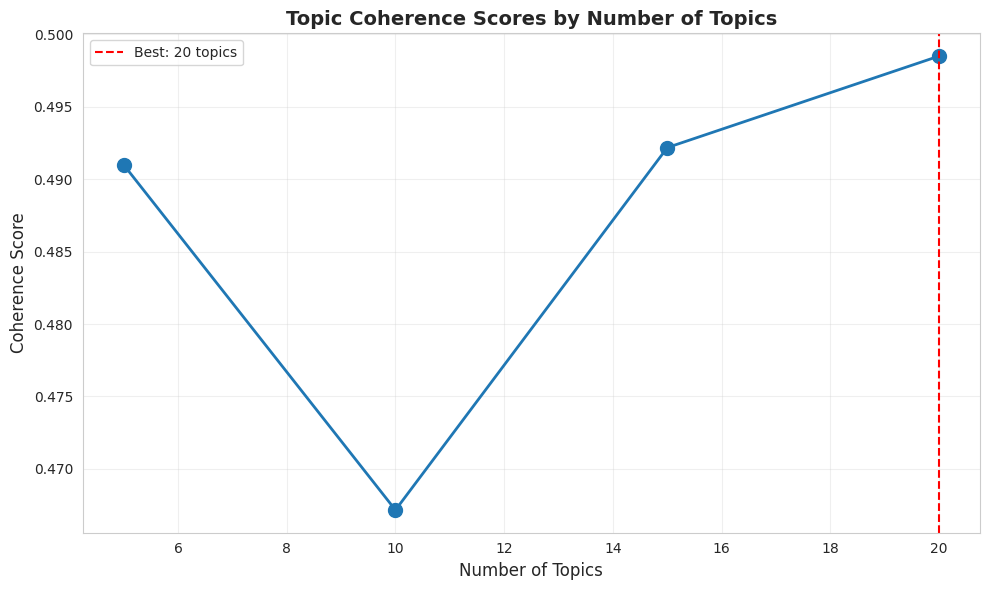

In [ ]:
# Visualize coherence scores
print("="*80)
print("COHERENCE SCORES COMPARISON")
print("="*80)

# Create DataFrame for visualization
coherence_df = pd.DataFrame({
    'Number of Topics': list(coherence_scores.keys()),
    'Coherence Score': list(coherence_scores.values())
})

print("\nCoherence Scores:")
print(coherence_df.to_string(index=False))

# Find best number of topics
best_num_topics = max(coherence_scores, key=coherence_scores.get)
best_coherence = coherence_scores[best_num_topics]

print(f"\n{'='*80}")
print(f"✓ Best number of topics: {best_num_topics} (Coherence: {best_coherence:.4f})")
print(f"{'='*80}")

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(coherence_df['Number of Topics'], coherence_df['Coherence Score'],
         marker='o', linewidth=2, markersize=10)
plt.axvline(x=best_num_topics, color='r', linestyle='--',
           label=f'Best: {best_num_topics} topics')
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Coherence Score', fontsize=12)
plt.title('Topic Coherence Scores by Number of Topics', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Step 5: Analyze Best Model - Extract Topic Keywords

We'll use the best model (highest coherence score) to extract and display topic keywords.


In [ ]:
# Select the best model
best_lda_model = lda_models[best_num_topics]

print("="*80)
print(f"TOPIC KEYWORDS - {best_num_topics} Topics")
print("="*80)

# Extract and display topics
num_words = 10  # Number of keywords to show per topic

topics = best_lda_model.print_topics(num_topics=best_num_topics, num_words=num_words)

print(f"\nShowing top {num_words} keywords for each topic:\n")

for topic_id, topic_keywords in topics:
    print(f"Topic {topic_id}:")
    print(f"  {topic_keywords}")
    print()

# Store topics for later use
topic_keywords_dict = {}
for topic_id, topic_keywords in topics:
    # Extract keywords from the topic string
    keywords_str = topic_keywords
    # Parse the string to get individual words and their probabilities
    words_probs = re.findall(r'\"([^\"]+)\"', keywords_str)
    topic_keywords_dict[topic_id] = words_probs

print("="*80)


TOPIC KEYWORDS - 20 Topics

Showing top 10 keywords for each topic:

Topic 0:
  0.037*"finland" + 0.025*"also" + 0.023*"companies" + 0.019*"atria" + 0.019*"one" + 0.019*"points" + 0.018*"targets" + 0.017*"percentage" + 0.016*"says" + 0.016*"customers"

Topic 1:
  0.166*"mln" + 0.088*"euro" + 0.044*"net" + 0.040*"2007" + 0.039*"oyj" + 0.038*"profit" + 0.036*"finnish" + 0.033*"2006" + 0.023*"said" + 0.023*"period"

Topic 2:
  0.047*"contract" + 0.047*"sales" + 0.030*"electronics" + 0.025*"finnish" + 0.025*"finland" + 0.025*"scanfil" + 0.024*"manufacturer" + 0.018*"due" + 0.018*"helsinki" + 0.017*"baltic"

Topic 3:
  0.193*"eur" + 0.067*"profit" + 0.051*"operating" + 0.044*"decreased" + 0.044*"sales" + 0.037*"period" + 0.033*"net" + 0.028*"quarter" + 0.024*"2008" + 0.023*"corresponding"

Topic 4:
  0.023*"yit" + 0.020*"price" + 0.019*"city" + 0.018*"percent" + 0.017*"capman" + 0.014*"work" + 0.014*"fall" + 0.013*"acquisition" + 0.013*"members" + 0.012*"street"

Topic 5:
  0.045*"company" 

In [ ]:
# Display topics in a more readable format
print("\n" + "="*80)
print("TOPIC KEYWORDS (Formatted)")
print("="*80)

for topic_id in range(best_num_topics):
    keywords = topic_keywords_dict[topic_id]
    print(f"\nTopic {topic_id}:")
    print(f"  Keywords: {', '.join(keywords[:10])}")

print("\n" + "="*80)



TOPIC KEYWORDS (Formatted)

Topic 0:
  Keywords: finland, also, companies, atria, one, points, targets, percentage, says, customers

Topic 1:
  Keywords: mln, euro, net, 2007, oyj, profit, finnish, 2006, said, period

Topic 2:
  Keywords: contract, sales, electronics, finnish, finland, scanfil, manufacturer, due, helsinki, baltic

Topic 3:
  Keywords: eur, profit, operating, decreased, sales, period, net, quarter, 2008, corresponding

Topic 4:
  Keywords: yit, price, city, percent, capman, work, fall, acquisition, members, street

Topic 5:
  Keywords: company, plant, results, according, eur0, structures, operations, russia, current, latvia

Topic 6:
  Keywords: new, basware, team, group, inc, shop, employees, sale, offer, remain

Topic 7:
  Keywords: quarter, year, fourth, improvement, half, first, operating, third, division, eur2

Topic 8:
  Keywords: financial, report, order, interim, 2010, 2009, area, orders, cargo, received

Topic 9:
  Keywords: products, business, project, glasto

## Step 6: Assign Topics to Each Sentence

Assign the dominant topic to each sentence/document in the dataset.


In [ ]:
# Assign topics to each document
print("="*80)
print("ASSIGNING TOPICS TO DOCUMENTS")
print("="*80)

def get_dominant_topic(corpus, model):
    """Get the dominant topic for each document"""
    topic_assignments = []
    topic_probs = []

    for doc_bow in corpus:
        # Get topic distribution for this document
        topic_dist = model.get_document_topics(doc_bow, minimum_probability=0.0)
        # Sort by probability
        topic_dist_sorted = sorted(topic_dist, key=lambda x: x[1], reverse=True)
        # Get dominant topic
        dominant_topic_id, dominant_topic_prob = topic_dist_sorted[0]
        topic_assignments.append(dominant_topic_id)
        topic_probs.append(dominant_topic_prob)

    return topic_assignments, topic_probs

# Assign topics using the best model
print("\nAssigning topics using best model...")
df_lda['dominant_topic'], df_lda['topic_probability'] = get_dominant_topic(corpus, best_lda_model)

print(f"✓ Topics assigned to {len(df_lda)} documents")

# Show topic distribution
print("\n" + "="*80)
print("TOPIC DISTRIBUTION")
print("="*80)
topic_counts = df_lda['dominant_topic'].value_counts().sort_index()
for topic_id, count in topic_counts.items():
    percentage = (count / len(df_lda)) * 100
    keywords = ', '.join(topic_keywords_dict[topic_id][:5])
    print(f"Topic {topic_id}: {count:,} documents ({percentage:.2f}%) - Keywords: {keywords}")


ASSIGNING TOPICS TO DOCUMENTS

Assigning topics using best model...
✓ Topics assigned to 2245 documents

TOPIC DISTRIBUTION
Topic 0: 72 documents (3.21%) - Keywords: finland, also, companies, atria, one
Topic 1: 97 documents (4.32%) - Keywords: mln, euro, net, 2007, oyj
Topic 2: 97 documents (4.32%) - Keywords: contract, sales, electronics, finnish, finland
Topic 3: 409 documents (18.22%) - Keywords: eur, profit, operating, decreased, sales
Topic 4: 86 documents (3.83%) - Keywords: yit, price, city, percent, capman
Topic 5: 96 documents (4.28%) - Keywords: company, plant, results, according, eur0
Topic 6: 96 documents (4.28%) - Keywords: new, basware, team, group, inc
Topic 7: 65 documents (2.90%) - Keywords: quarter, year, fourth, improvement, half
Topic 8: 84 documents (3.74%) - Keywords: financial, report, order, interim, 2010
Topic 9: 80 documents (3.56%) - Keywords: products, business, project, glaston, demand
Topic 10: 93 documents (4.14%) - Keywords: company, market, based, marg

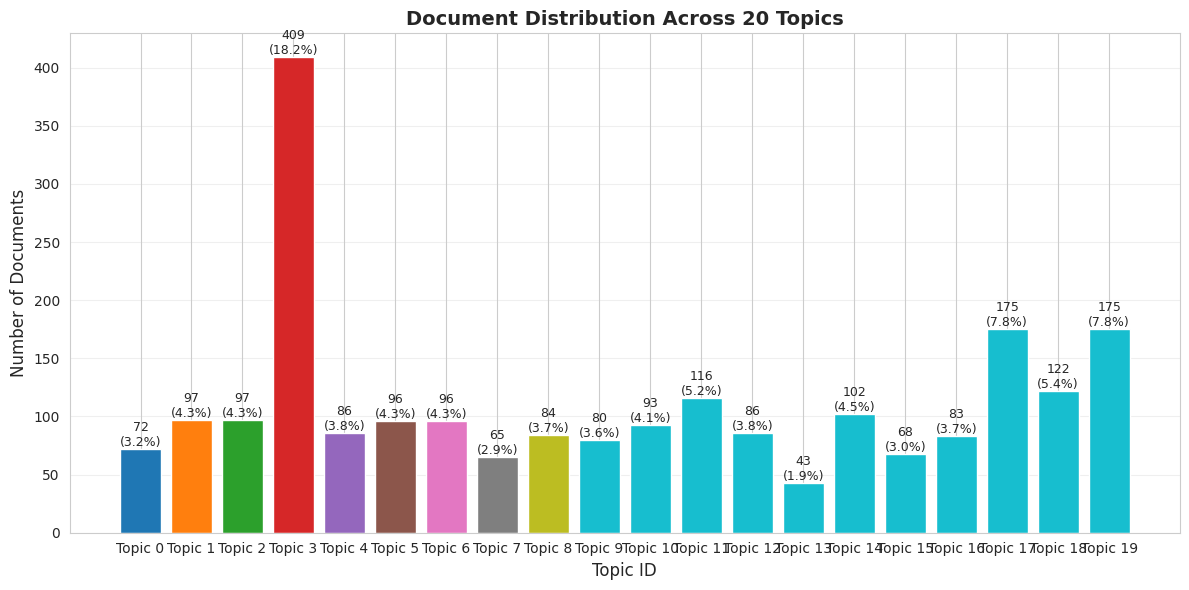

In [ ]:
# Visualize topic distribution
plt.figure(figsize=(12, 6))
topic_counts_sorted = df_lda['dominant_topic'].value_counts().sort_index()
bars = plt.bar(range(len(topic_counts_sorted)), topic_counts_sorted.values,
               color=plt.cm.tab10(range(len(topic_counts_sorted))))
plt.xlabel('Topic ID', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.title(f'Document Distribution Across {best_num_topics} Topics', fontsize=14, fontweight='bold')
plt.xticks(range(len(topic_counts_sorted)), [f'Topic {i}' for i in topic_counts_sorted.index])
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (topic_id, count) in enumerate(topic_counts_sorted.items()):
    percentage = (count / len(df_lda)) * 100
    plt.text(i, count, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Step 7: Topic Interpretation and Labeling

Interpret each topic based on its keywords and assign descriptive labels.


In [ ]:
# Interpret topics and assign labels
print("="*80)
print("TOPIC INTERPRETATION AND LABELING")
print("="*80)

# Display each topic with keywords and sample sentences
topic_interpretations = {}

for topic_id in range(best_num_topics):
    keywords = topic_keywords_dict[topic_id]
    topic_docs = df_lda[df_lda['dominant_topic'] == topic_id]

    print(f"\n{'='*80}")
    print(f"TOPIC {topic_id}")
    print(f"{'='*80}")
    print(f"\nTop Keywords: {', '.join(keywords[:10])}")
    print(f"\nNumber of documents: {len(topic_docs)}")
    print(f"Average topic probability: {topic_docs['topic_probability'].mean():.3f}")

    # Show sample sentences for this topic
    print(f"\nSample sentences from this topic:")
    sample_sentences = topic_docs.nlargest(3, 'topic_probability')['sentence'].tolist()
    for i, sentence in enumerate(sample_sentences, 1):
        print(f"  {i}. {sentence[:100]}...")

    # Store for later
    topic_interpretations[topic_id] = {
        'keywords': keywords,
        'num_documents': len(topic_docs),
        'avg_probability': topic_docs['topic_probability'].mean()
    }

print("\n" + "="*80)


TOPIC INTERPRETATION AND LABELING

TOPIC 0

Top Keywords: finland, also, companies, atria, one, points, targets, percentage, says, customers

Number of documents: 72
Average topic probability: 0.519

Sample sentences from this topic:
  1. Rapala aims to move the distribution unit Ragot from Loudeac in Bretagne and the distribution unit W...
  2. One price category is for calls on the preferred operator 's network , and another for calls on othe...
  3. Currently the Terminator lures are produced in a subcontract facility in Mexico but the manufacturin...

TOPIC 1

Top Keywords: mln, euro, net, 2007, oyj, profit, finnish, 2006, said, period

Number of documents: 97
Average topic probability: 0.557

Sample sentences from this topic:
  1. Finnish metal products company Componenta Oyj net profit rose to 26.1 mln euro ( $ 35.9 mln ) for th...
  2. Finnish financial software solutions developer BasWare Oyj said its net profit fell to 884,000 euro ...
  3. Finnish office supplies and computer

In [ ]:
# Create topic labels based on keywords (manual interpretation)
# Users can modify these labels based on their analysis

topic_labels = {}
for topic_id in range(best_num_topics):
    keywords = topic_keywords_dict[topic_id][:10]
    keywords_lower = [k.lower() for k in keywords]

    # Automatic label suggestion based on keywords
    label = "Unknown Topic"

    # Financial performance keywords
    if any(kw in keywords_lower for kw in ['profit', 'sales', 'revenue', 'earnings', 'income']):
        if any(kw in keywords_lower for kw in ['operating', 'net', 'quarter']):
            label = "Company Financial Performance"
        else:
            label = "Revenue and Earnings"

    # Market and trading keywords
    elif any(kw in keywords_lower for kw in ['shares', 'market', 'trading', 'stock', 'price']):
        label = "Market Movement and Trading"

    # Business operations keywords
    elif any(kw in keywords_lower for kw in ['company', 'business', 'operations', 'division']):
        label = "Company Operations and Business"

    # Growth and expansion keywords
    elif any(kw in keywords_lower for kw in ['increased', 'growth', 'rose', 'higher', 'doubled']):
        label = "Growth and Expansion"

    # Financial terms
    elif any(kw in keywords_lower for kw in ['eur', 'million', 'billion', 'currency']):
        label = "Financial Metrics and Currency"

    topic_labels[topic_id] = label

# Display topic labels
print("="*80)
print("TOPIC LABELS (Suggested)")
print("="*80)
print("\nNote: These are automatic suggestions. Please review and modify based on your analysis.\n")

for topic_id in range(best_num_topics):
    keywords = ', '.join(topic_keywords_dict[topic_id][:8])
    print(f"Topic {topic_id}: {topic_labels[topic_id]}")
    print(f"  Keywords: {keywords}")
    print()

print("="*80)


TOPIC LABELS (Suggested)

Note: These are automatic suggestions. Please review and modify based on your analysis.

Topic 0: Unknown Topic
  Keywords: finland, also, companies, atria, one, points, targets, percentage

Topic 1: Company Financial Performance
  Keywords: mln, euro, net, 2007, oyj, profit, finnish, 2006

Topic 2: Revenue and Earnings
  Keywords: contract, sales, electronics, finnish, finland, scanfil, manufacturer, due

Topic 3: Company Financial Performance
  Keywords: eur, profit, operating, decreased, sales, period, net, quarter

Topic 4: Market Movement and Trading
  Keywords: yit, price, city, percent, capman, work, fall, acquisition

Topic 5: Company Operations and Business
  Keywords: company, plant, results, according, eur0, structures, operations, russia

Topic 6: Unknown Topic
  Keywords: new, basware, team, group, inc, shop, employees, sale

Topic 7: Company Operations and Business
  Keywords: quarter, year, fourth, improvement, half, first, operating, third

Top

## Step 8: Save Results

Save the topic assignments and model results for use in subsequent tasks.


In [ ]:
# Merge topic assignments back to original dataframe
print("Saving results...")

# Create a mapping from df_lda index to original df
df_with_topics = df.copy()
df_with_topics['dominant_topic'] = np.nan
df_with_topics['topic_probability'] = np.nan
df_with_topics['topic_label'] = ''

# Map topics back to original dataframe
for idx in df_lda.index:
    if idx in df_with_topics.index:
        df_with_topics.loc[idx, 'dominant_topic'] = df_lda.loc[idx, 'dominant_topic']
        df_with_topics.loc[idx, 'topic_probability'] = df_lda.loc[idx, 'topic_probability']
        df_with_topics.loc[idx, 'topic_label'] = topic_labels.get(df_lda.loc[idx, 'dominant_topic'], 'Unknown')

# Save dataset with topic assignments
output_file = 'dataset_with_topics.csv'
df_with_topics.to_csv(output_file, index=False, encoding='utf-8')

print(f"✓ Dataset with topic assignments saved to: {output_file}")
print(f"✓ Total rows: {len(df_with_topics):,}")
print(f"✓ Rows with topic assignments: {df_with_topics['dominant_topic'].notna().sum():,}")

# Display summary
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
print(f"\nBest number of topics: {best_num_topics}")
print(f"Best coherence score: {best_coherence:.4f}")
print(f"\nTopic distribution:")
topic_dist = df_with_topics['dominant_topic'].value_counts().sort_index()
for topic_id in topic_dist.index:
    if pd.notna(topic_id):
        count = topic_dist[topic_id]
        label = topic_labels.get(int(topic_id), 'Unknown')
        print(f"  Topic {int(topic_id)} ({label}): {count:,} documents")


Saving results...
✓ Dataset with topic assignments saved to: dataset_with_topics.csv
✓ Total rows: 2,264
✓ Rows with topic assignments: 2,245

SUMMARY

Best number of topics: 20
Best coherence score: 0.4985

Topic distribution:
  Topic 0 (Unknown Topic): 72 documents
  Topic 1 (Company Financial Performance): 97 documents
  Topic 2 (Revenue and Earnings): 97 documents
  Topic 3 (Company Financial Performance): 409 documents
  Topic 4 (Market Movement and Trading): 86 documents
  Topic 5 (Company Operations and Business): 96 documents
  Topic 6 (Unknown Topic): 96 documents
  Topic 7 (Company Operations and Business): 65 documents
  Topic 8 (Unknown Topic): 84 documents
  Topic 9 (Company Operations and Business): 80 documents
  Topic 10 (Market Movement and Trading): 93 documents
  Topic 11 (Company Operations and Business): 116 documents
  Topic 12 (Revenue and Earnings): 86 documents
  Topic 13 (Unknown Topic): 43 documents
  Topic 14 (Financial Metrics and Currency): 102 documents
 

In [ ]:
# Download results (Google Colab only)
try:
    from google.colab import files
    files.download(output_file)
    print(f"✓ Downloaded: {output_file}")
except ImportError:
    print("Not in Google Colab. File saved locally.")

# Display sample of results
print(f"\n{'='*80}")
print("SAMPLE RESULTS")
print(f"{'='*80}")
sample_cols = ['sentence', 'sentiment', 'dominant_topic', 'topic_label', 'topic_probability']
display_cols = [col for col in sample_cols if col in df_with_topics.columns]
print(f"\nSample rows with topic assignments:")
display(df_with_topics[display_cols].head(10))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: dataset_with_topics.csv

SAMPLE RESULTS

Sample rows with topic assignments:


,sentence,sentiment,dominant_topic,topic_label,topic_probability
0,"According to Gran , the company has no plans t...",neutral,5.0,Company Operations and Business,0.473686
1,"For the last quarter of 2010 , Componenta 's n...",positive,3.0,Company Financial Performance,0.578452
2,"In the third quarter of 2010 , net sales incre...",positive,3.0,Company Financial Performance,0.845967
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,3.0,Company Financial Performance,0.933185
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,3.0,Company Financial Performance,0.921095
5,Finnish Talentum reports its operating profit ...,positive,3.0,Company Financial Performance,0.830564
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,positive,3.0,Company Financial Performance,0.511771
7,Consolidated net sales increased 16 % to reach...,positive,3.0,Company Financial Performance,0.809882
8,Foundries division reports its sales increased...,positive,3.0,Company Financial Performance,0.629084
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",positive,19.0,Financial Metrics and Currency,0.375463


## Summary

### Task 2 Completed: LDA Topic Modeling

✅ **Data Preparation**: Prepared preprocessed text for LDA  
✅ **LDA Implementation**: Trained LDA models with different topic numbers  
✅ **Topic Selection**: Selected optimal number of topics based on coherence scores  
✅ **Topic Keywords**: Extracted and displayed keywords for each topic  
✅ **Topic Assignment**: Assigned dominant topics to each sentence  
✅ **Topic Interpretation**: Interpreted and labeled each topic  

### Key Results:
- **Optimal number of topics**: {best_num_topics}
- **Coherence score**: {best_coherence:.4f}
- **Topics discovered**: {len(topic_labels)} distinct topics
- **Documents with topics**: {df_with_topics['dominant_topic'].notna().sum():,}

### Next Steps:
- Proceed to **Task 3: Sentiment Analysis** (FinBERT, Local LLM, RAG)
- Use the topic assignments for enhanced analysis
